Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2018/2019  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 5: Probabilistički grafički modeli, naivni Bayes, grupiranje i vrednovanje klasifikatora

*Verzija: 1.4  
Zadnji put ažurirano: 11. siječnja 2019.*

(c) 2015-2019 Jan Šnajder, Domagoj Alagić  

Objavljeno: **11. siječnja 2019.**  
Rok za predaju: **21. siječnja 2019. u 07:00h**

------------------------------

### Upute

Peta laboratorijska vježba sastoji se od tri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import codecs
import mlutils
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate.

#### (a)  
Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb)).

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

In [35]:
model = BayesianModel([('C', 'R'), ('C', 'S'), ('R', 'W'), ('S', 'W')])
cpd_c = TabularCPD('C', 2, [[0.5, 0.5]])
cpd_r = TabularCPD('R', 2, [[0.8, 0.2], [0.2, 0.8]], evidence=['C'], evidence_card=[2])
cpd_s = TabularCPD('S', 2, [[0.5, 0.9], [0.5, 0.1]], evidence=['C'], evidence_card=[2])
cpd_w = TabularCPD('W', 2, [[1, 0.1, 0.1, .01],  [0, 0.9, 0.9, 0.99]], evidence=['S', 'R'], evidence_card=[2, 2])

model.add_cpds(cpd_c, cpd_r, cpd_s, cpd_w)
# model.check_model()

infer = VariableElimination(model)
print(infer.query(['W']) ['W'])
print(infer.query(['S'], evidence={'W': 1}) ['S'])
print(infer.query(['R'], evidence={'W': 1}) ['R'])
print(infer.query(['C'], evidence={'S': 1, 'R': 1}) ['C'])
print(infer.query(['C']) ['C'])

+-----+----------+
| W   |   phi(W) |
+=====+==========+
| W_0 |   0.3529 |
+-----+----------+
| W_1 |   0.6471 |
+-----+----------+
+-----+----------+
| S   |   phi(S) |
+=====+==========+
| S_0 |   0.5702 |
+-----+----------+
| S_1 |   0.4298 |
+-----+----------+
+-----+----------+
| R   |   phi(R) |
+=====+==========+
| R_0 |   0.2921 |
+-----+----------+
| R_1 |   0.7079 |
+-----+----------+
+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.5556 |
+-----+----------+
| C_1 |   0.4444 |
+-----+----------+
+-----+----------+
| C   |   phi(C) |
+=====+==========+
| C_0 |   0.5000 |
+-----+----------+
| C_1 |   0.5000 |
+-----+----------+


**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?  
**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  
**Q:** Koja je razlika između posteriornog upita i MAP-upita?  
**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

#### (b)  
**Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [4]:
print(infer.query(['S'], evidence={'W': 1, 'R':1}) ['S'])
print(infer.query(['S'], evidence={'W': 1, 'R':0}) ['S'])
print(infer.query(['R'], evidence={'W': 1, 'S':1}) ['R'])
print(infer.query(['R'], evidence={'W': 1, 'S':0}) ['R'])

+-----+----------+
| S   |   phi(S) |
+=====+==========+
| S_0 |   0.8055 |
+-----+----------+
| S_1 |   0.1945 |
+-----+----------+
+-----+----------+
| S   |   phi(S) |
+=====+==========+
| S_0 |   0.0000 |
+-----+----------+
| S_1 |   1.0000 |
+-----+----------+
+-----+----------+
| R   |   phi(R) |
+=====+==========+
| R_0 |   0.6796 |
+-----+----------+
| R_1 |   0.3204 |
+-----+----------+
+-----+----------+
| R   |   phi(R) |
+=====+==========+
| R_0 |   0.0000 |
+-----+----------+
| R_1 |   1.0000 |
+-----+----------+


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom?

#### (c)  
Koristeći [`BayesianModel.is_active_trail`](http://pgmpy.org/models.html#pgmpy.models.BayesianModel.BayesianModel.is_active_trail) provjerite jesu li varijable oblačnosti ($C$) i mokre trave ($W$) uvjetno nezavisne. Što mora vrijediti kako bi te dvije varijable bile uvjetno nezavisne? Provjerite korištenjem iste funkcije.

In [5]:
print(model.is_active_trail('C', 'W'))

print(model.is_active_trail('C', 'W', observed=['S', 'R']))

True
False


**Q:** Kako možemo na temelju grafa saznati koje dvije varijable su, uz neka opažanja, uvjetno nezavisne?  
**Q:** Zašto bismo uopće htjeli znati koje su varijable u mreži uvjetno nezavisne?

### 2. Vrednovanje modela (klasifikatora)  

Kako bismo se uvjerili koliko naš naučeni model zapravo dobro radi, nužno je provesti evaluaciju modela. Ovaj korak od presudne je važnosti u svim primjenama strojnog učenja, pa je stoga bitno znati provesti evaluaciju na ispravan način.

Vrednovat ćemo modele na stvarnom skupu podataka [*SMS Spam Collection*](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) [1], koji se sastoji od 5,574 SMS-poruka klasificiranih u dvije klase: spam (oznaka: *spam*) i ne-spam (oznaka: *ham*). Ako već niste, preuzmite skup podataka s poveznice ili sa stranice kolegija i stavite ga u radni direktorij (otpakirajte arhivu i preimenujte datoteku u `spam.csv` po potrebi). Sljedeći komad kôda učitava skup podataka i dijeli ga na podskupove za učenje i testiranje.

[1] *Almeida, T.A., GÃmez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.*

In [6]:
from sklearn.model_selection import train_test_split
spam_X, spam_y = mlutils.load_SMS_dataset('D:/Danijel/Shit for college/4 Godina/Strojno Učenje/spam.csv')

spam_X_train, spam_X_test, spam_y_train, spam_y_test = \
    train_test_split(spam_X, spam_y, train_size=0.7, test_size=0.3, random_state=69)

#### (a)  
Prije nego što krenemo u vrednovanje modela za klasifikaciju spama, upoznat ćete se s jednostavnijom apstrakcijom cjelokupnog procesa učenja modela u biblioteci `scikit-learn`. Ovo je korisno zato što se učenje modela često sastoji od mnoštva koraka prije sâmog pozivanja magične funkcije `fit`: ekstrakcije podataka, ekstrakcije značajki, standardizacije, skaliranja, nadopunjavanjem nedostajućih vrijednosti i slično. 

U "standardnom pristupu", ovo se svodi na pozamašan broj linija kôda u kojoj konstantno proslijeđujemo podatke iz jednog koraka u sljedeći, tvoreći pritom cjevovod izvođenja. Osim nepreglednosti, ovakav pristup je često i sklon pogreškama, s obzirom na to da je dosta jednostavno proslijediti pogrešan skup podataka i ne dobiti pogrešku pri izvođenju kôda. Stoga je u biblioteci `scikit-learn` uveden razred [`pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Kroz ovaj razred, svi potrebni koraci učenja mogu se apstrahirati iza jednog cjevovoda, koji je opet zapravo model s `fit` i `predict` funkcijama.

U ovom zadatku ćete napraviti samo jednostavni cjevovod modela za klasifikaciju teksta, koji se sastoji od pretvorbe teksta u vektorsku reprezentaciju vreće riječi s TF-IDF-težinama, redukcije dimenzionalnosti pomoću krnje dekompozicije singularnih vrijednosti, normalizacije, te konačno logističke regresije.

**NB:** Nije sasvim nužno znati kako rade ovi razredi pomoću kojih dolazimo do konačnih značajki, ali preporučamo da ih proučite ako vas zanima (posebice ako vas zanima obrada prirodnog jezika).

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Prvo, prilažemo kôd koji to radi "standardnim pristupom":

In [8]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=500)
spam_X_feat_train = vectorizer.fit_transform(spam_X_train)
# Smanjenje dimenzionalnosti
reducer = TruncatedSVD(n_components=300, random_state=69)
spam_X_feat_train = reducer.fit_transform(spam_X_feat_train)
# Normaliziranje
normalizer = Normalizer()
spam_X_feat_train = normalizer.fit_transform(spam_X_feat_train)
# NB
clf = LogisticRegression(solver='lbfgs')
clf.fit(spam_X_feat_train, spam_y_train)

# I sada ponovno sve ovo za testne podatke.
spam_X_feat_test = vectorizer.transform(spam_X_test)
spam_X_feat_test = reducer.transform(spam_X_feat_test)
spam_X_feat_test = normalizer.transform(spam_X_feat_test)

print(accuracy_score(spam_y_test, clf.predict(spam_X_feat_test)))

x_test = ["You were selected for a green card, apply here for only 50 USD!!!",
         "Hey, what are you doing later? Want to grab a cup of coffee?"]
x_test = vectorizer.transform(x_test)
x_test = reducer.transform(x_test)
x_test = normalizer.transform(x_test)
print(clf.predict(x_test))

0.9659294680215182
['spam' 'ham']


Vaš zadatak izvesti je dani kôd korištenjem cjevovoda. Proučite razred [`pipeline.Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

**NB** Ne treba vam više od svega nekoliko naredbi.

In [9]:
import numpy as np

clf2 = LogisticRegression(solver='lbfgs')
pipeline = Pipeline([('vectorizer', vectorizer), ('reducer', reducer), ('normalizer', normalizer), ('clf', clf2)])
spam_X_pipe_train = pipeline.fit(spam_X_train, spam_y_train)
prediction = pipeline.predict(spam_X_test)

print(accuracy_score(spam_y_test, prediction))
x_test_pipe = ["You were selected for a green card, apply here for only 50 USD!!!",
         "Hey, what are you doing later? Want to grab a cup of coffee?"]
y_pred_pipe = pipeline.predict(x_test_pipe)
print(y_pred_pipe)

0.9659294680215182
['spam' 'ham']


#### (b)  
U prošlom smo podzadatku ispisali točnost našeg modela. Ako želimo vidjeti koliko je naš model dobar po ostalim metrikama, možemo iskoristiti bilo koju funkciju iz paketa [`metrics`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Poslužite se funkcijom [`metrics.classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report), koja ispisuje vrijednosti najčešćih metrika. (Obavezno koristite naredbu `print` kako ne biste izgubili format izlaza funkcije.) Ispišite ponovno točnost za usporedbu.

In [10]:
from sklearn.metrics import classification_report, accuracy_score

In [11]:
print(accuracy_score(spam_y_test, pipeline.predict(spam_X_test)))
print(classification_report(spam_y_test, pipeline.predict(spam_X_test)))

0.9659294680215182
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1439
        spam       0.97      0.78      0.86       234

   micro avg       0.97      0.97      0.97      1673
   macro avg       0.97      0.89      0.92      1673
weighted avg       0.97      0.97      0.96      1673



Potreba za drugim metrikama osim točnosti može se vidjeti pri korištenju nekih osnovnih modela (engl. *baselines*). Možda najjednostavniji model takvog tipa je model koji svrstava sve primjere u većinsku klasu (engl. *most frequent class*; MFC) ili označuje testne primjere nasumično (engl. *random*). Proučite razred [`dummy.DummyClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) i pomoću njega stvorite spomenute osnovne klasifikatore. Opet ćete trebati iskoristiti cjevovod kako biste došli do vektorskog oblika ulaznih primjera, makar ovi osnovni klasifikatori koriste samo oznake pri predikciji.

In [12]:
from sklearn.dummy import DummyClassifier

mf = Pipeline([('vectorizer', vectorizer),('reducer', reducer),\
               ('normalizer', normalizer),('clf', DummyClassifier('most_frequent'))])
mf.fit(spam_X_train, spam_y_train)
rd = Pipeline([('vectorizer', vectorizer),('reducer', reducer),\
               ('normalizer', normalizer),('clf', DummyClassifier('uniform'))])
rd.fit(spam_X_train, spam_y_train)

print(classification_report(spam_y_test, mf.predict(spam_X_test)))
print(classification_report(spam_y_test, rd.predict(spam_X_test)))

              precision    recall  f1-score   support

         ham       0.86      1.00      0.92      1439
        spam       0.00      0.00      0.00       234

   micro avg       0.86      0.86      0.86      1673
   macro avg       0.43      0.50      0.46      1673
weighted avg       0.74      0.86      0.80      1673

              precision    recall  f1-score   support

         ham       0.86      0.50      0.63      1439
        spam       0.14      0.50      0.22       234

   micro avg       0.50      0.50      0.50      1673
   macro avg       0.50      0.50      0.43      1673
weighted avg       0.76      0.50      0.58      1673



c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Q:** Na temelju ovog primjera objasnite zašto točnost nije uvijek prikladna metrika.  
**Q:** Zašto koristimo F1-mjeru?

#### (c)  
Međutim, provjera za kakvom smo posegli u prošlom podzadatku nije robusna. Stoga se u strojnom učenju obično koristi k-struka unakrsna provjera. Proučite razred [`model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) i funkciju [`model_selection.cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) te izračunajte procjenu pogreške na cijelom skupu podataka koristeći peterostruku unakrsnu provjeru. 

**NB:** Vaš model je sada cjevovod koji sadrži čitavo pretprocesiranje. Također, u nastavku ćemo se ograničiti na točnost, ali ovi postupci vrijede za sve metrike.

In [13]:
from sklearn.model_selection import cross_val_score, KFold

In [14]:
kf = KFold(n_splits=5)
avg = list()
clf3 = LogisticRegression(solver='lbfgs')
pipeline2 = Pipeline([('vectorizer', vectorizer), ('reducer', reducer), ('normalizer', normalizer), ('clf', clf3)])
for train_index, test_index in kf.split(spam_X, spam_y):
    
    pipeline2.fit(spam_X[train_index], spam_y[train_index])
    
    avg.append((mean(cross_val_score(pipeline2, spam_X[test_index], spam_y[test_index], cv=5))))
print(mean(avg))

0.9459874704941971


**Q:** Zašto "obična" unakrsna provjera nije dovoljno robusna?  
**Q:** Što je to stratificirana k-struka unakrsna provjera? Zašto ju često koristimo?  

#### (d)  

Gornja procjena pogreške je u redu ako imamo već imamo model (bez ili s fiksiranim hiperparametrima). Međutim, mi želimo koristiti model koji ima optimalne vrijednosti hiperparametara te ih je stoga potrebno optimirati korištenjem pretraživanja po rešetci (engl. *grid search*). Očekivano, biblioteka `scikit-learn` već ima ovu funkcionalnost u razredu [`model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Jedina razlika vaše implementacije iz prošlih vježbi (npr. kod SVM-a) i ove jest ta da ova koristi k-struku unakrsnu provjeru.

Prije optimizacije vrijednosti hiperparametara, očigledno moramo definirati i samu rešetku vrijednosti hiperparametara. Proučite kako se definira ista kroz rječnik u [primjeru](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py). 

Proučite spomenuti razred te pomoću njega pronađite i ispišite najbolje vrijednosti hiperparametara cjevovoda iz podzadatka (a): `max_features` $\in \{500, 1000\}$ i `n_components` $\in \{ 100, 200, 300 \}$ korištenjem pretraživanja po rešetci na skupu za učenje ($k=3$, kako bi išlo malo brže).

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
parameters = {
    'vectorizer__max_features': (500, 1000),
    'reducer__n_components': (100, 200, 300)
}
grid_search = GridSearchCV(pipeline2, parameters, cv=3)
grid_search.fit(spam_X, spam_y)
best_params = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_params[param_name]))

	reducer__n_components: 300
	vectorizer__max_features: 1000


**Q:** Koja se metrika optimira pri ovoj optimizaciji?  
**Q:** Kako biste odredili broj preklopa $k$?  

#### (e)  
Ako želimo procijeniti pogrešku, ali pritom i napraviti odabir modela, tada se okrećemo ugniježđenoj k-strukoj unakrsnoj provjeri (engl. *nested k-fold cross validation*). U ovom zadatku ćete ju sami implementirati.

Implementirajte funkciju `nested_kfold_cv(clf, param_grid, X, y, k1, k2)` koja provodi ugniježđenu k-struku unakrsnu provjeru. Argument `clf` predstavlja vaš klasifikator, `param_grid` rječnik vrijednosti hiperparametara (isto kao i u podzadatku (d)), `X` i `y` označeni skup podataka, a `k1` i `k2` broj preklopa u vanjskoj, odnosno unutarnjoj petlji. Poslužite se razredima [`model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) i  [`model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

Funkcija vraća listu pogrešaka kroz preklope vanjske petlje.

In [17]:
from sklearn.model_selection import GridSearchCV, KFold

In [18]:
def nested_kfold_cv(clf, param_grid, X, y, k1=10, k2=3):
    kf = KFold(n_splits=k1)
    errors = list()
    for train_index, test_index in kf.split(X, y):
        grid_search = GridSearchCV(clf, param_grid, cv=k2)
        grid_search.fit(spam_X, spam_y)
        best_params = grid_search.best_estimator_.get_params()
        for param_name in sorted(param_grid.keys()):
            clf.set_params(param_name=best_params[param_name])
        errors.append(clf.score)       
    return errors

**Q:** Kako biste odabrali koji su hiperparametri generalno najbolji, a ne samo u svakoj pojedinačnoj unutarnjoj petlji?  
**Q:** Čemu u konačnici odgovara procjena generalizacijske pogreške?

#### (f)  
Scenarij koji nas najviše zanima jest usporedba dvaju klasifikatora, odnosno, je li jedan od njih zaista bolji od drugog. Jedini način kako to možemo zaista potvrditi jest statističkom testom, u našem slučaju **uparenim t-testom**. Njime ćemo se baviti u ovom zadatku.

Radi bržeg izvođenja, umjetno ćemo generirati podatke koji odgovaraju pogreškama kroz vanjske preklope dvaju klasifikatora (ono što bi vratila funkcija `nested_kfold_cv`):

In [19]:
np.random.seed(1337)
C1_scores_5folds = np.random.normal(78, 4, 5)
C2_scores_5folds = np.random.normal(81, 2, 5)

C1_scores_10folds = np.random.normal(78, 4, 10)
C2_scores_10folds = np.random.normal(81, 2, 10)

C1_scores_50folds = np.random.normal(78, 4, 50)
C2_scores_50folds = np.random.normal(81, 2, 50)

Iskoristite ugrađenu funkciju [`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html) za provedbu uparenog t-testa i provjerite koji od ova modela je bolji kada se koristi 5, 10 i 50 preklopa.

In [20]:
from scipy.stats import ttest_rel

In [21]:
print("k = 5 ->", ttest_rel(C1_scores_5folds, C2_scores_5folds))
print("k = 10 ->", ttest_rel(C1_scores_10folds, C2_scores_10folds))
print("k = 50 ->", ttest_rel(C1_scores_50folds, C2_scores_50folds))

k = 5 -> Ttest_relResult(statistic=-1.9936398023627793, pvalue=0.11696313548164915)
k = 10 -> Ttest_relResult(statistic=-0.8842099536936594, pvalue=0.3995873733387435)
k = 50 -> Ttest_relResult(statistic=-5.824055316050818, pvalue=4.3638376885602463e-07)


**Q:** Koju hipotezu $H_0$ i alternativnu hipotezu $H_1$ testiramo ovim testom?  
**Q:** Koja pretpostavka na vjerojatnosnu razdiobu primjera je napravljena u gornjem testu? Je li ona opravdana?  
**Q:** Koji je model u konačnici bolji i je li ta prednost značajna uz $\alpha = 0.05$?  

### 3. Grupiranje

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-means*), njegovim glavnim nedostatcima te pretpostavkama. Također ćete isprobati i drugi algoritam grupiranja: model Gaussovih mješavina (engl. *Gaussian mixture model*).

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

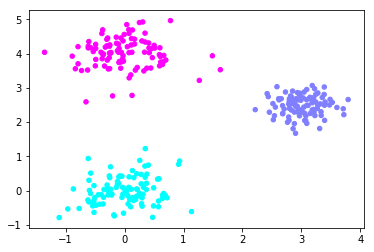

In [22]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

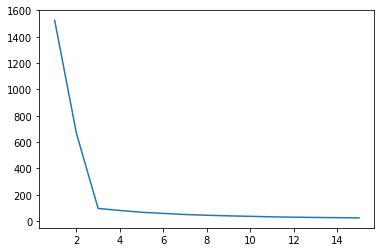

In [23]:
from sklearn.cluster import KMeans
J = list()
K = range(1, 16)

for k in K:
    J.append(KMeans(n_clusters=k).fit(Xp).inertia_)
plot(K, J);

**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate?    
**Q:** Je li ova metoda robusna?  
**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `mlutils.plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

For n_clusters = 2 The average silhouette_score is : 0.59280796169837


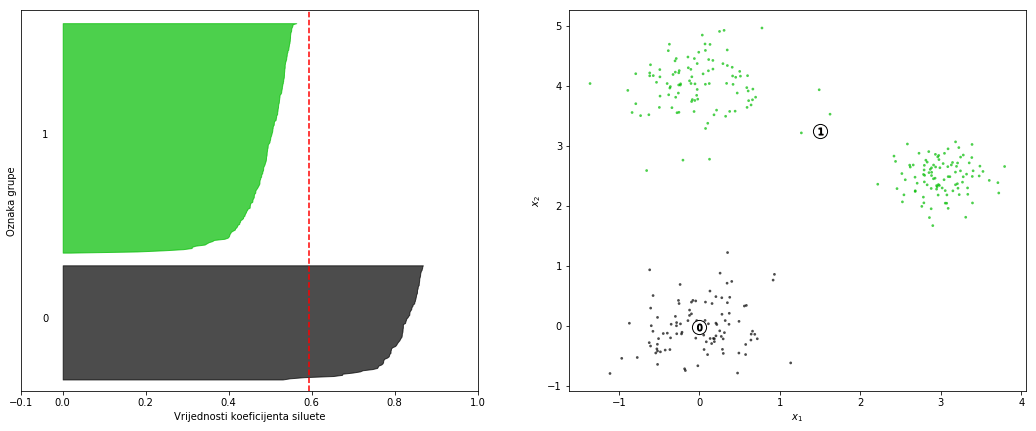

For n_clusters = 3 The average silhouette_score is : 0.7975462212061405


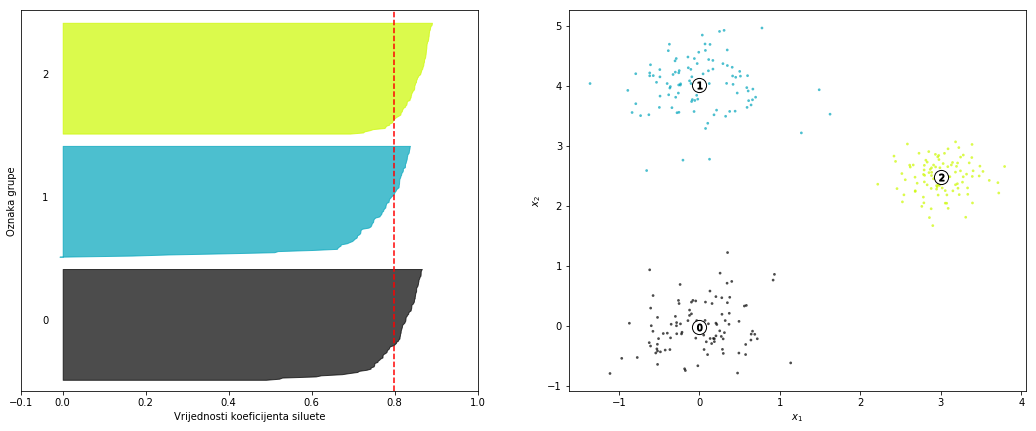

For n_clusters = 5 The average silhouette_score is : 0.5052371766008248


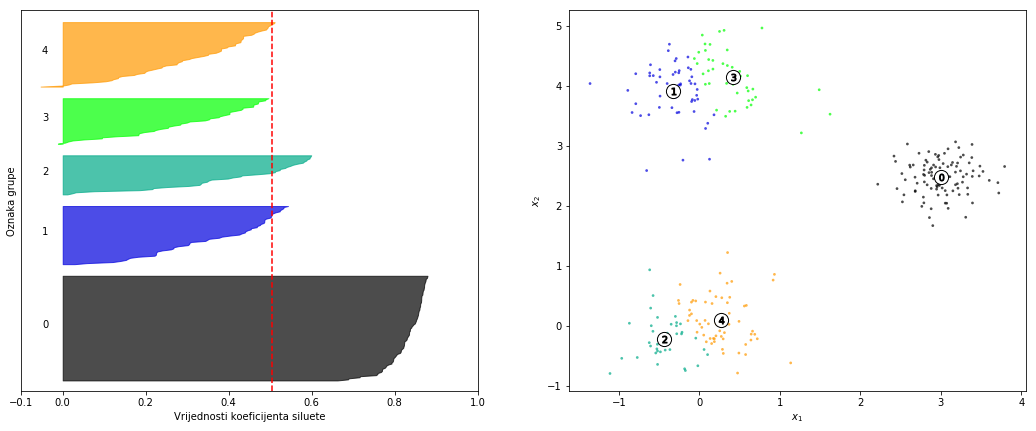

In [24]:
import mlutils

Ks = [2, 3, 5]
for k in Ks:
    mlutils.plot_silhouette(X=Xp, n_clusters=k)

**Q:** Kako biste se gledajući ove slike odlučili za $K$?  
**Q:** Koji su problemi ovog pristupa?

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-sredina te što se događa ako te pretpostavke nisu zadovoljene. Dodatno, isprobat ćemo i grupiranje modelom Gaussovih mješavina (engl. *Gaussian Mixture Models*; GMM) koji ne nema neke od tih pretpostavki.

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

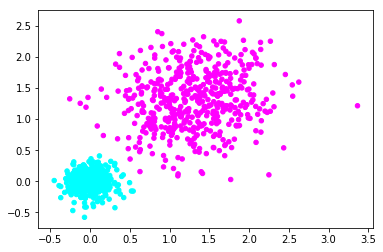

In [25]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

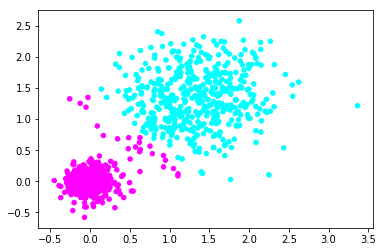

In [36]:
Kmodel = KMeans(n_clusters=2).fit(X1)

plt.scatter(X1[:,0], X1[:,1], c=Kmodel.predict(X1), cmap=plt.get_cmap("cool"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (d)

Isprobajte algoritam k-sredina na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

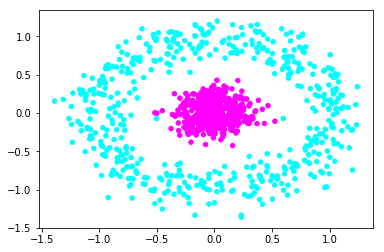

In [27]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Ponovno, naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

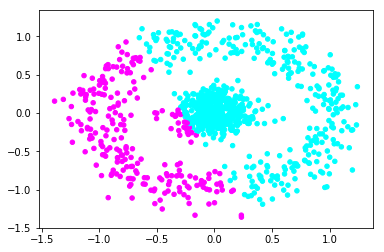

In [37]:
Kmodel = KMeans(n_clusters=2).fit(X2)

plt.scatter(X2[:,0], X2[:,1], c=Kmodel.predict(X2), cmap=plt.get_cmap("cool"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

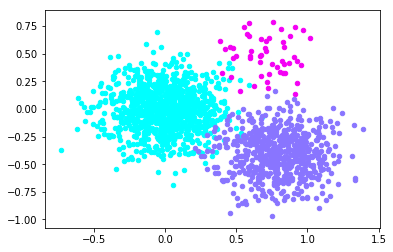

In [29]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-sredina (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

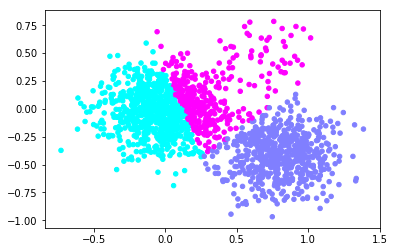

In [38]:
Kmodel = KMeans(n_clusters=3).fit(X3)
plt.scatter(X3[:,0], X3[:,1], c=Kmodel.predict(X3), cmap=plt.get_cmap("cool"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (f)  
Sada kada ste se upoznali s ograničenjima algoritma k-sredina, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-sredina (odnosno, algoritam k-sredina specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (c)-(e). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [31]:
from sklearn.mixture import GaussianMixture

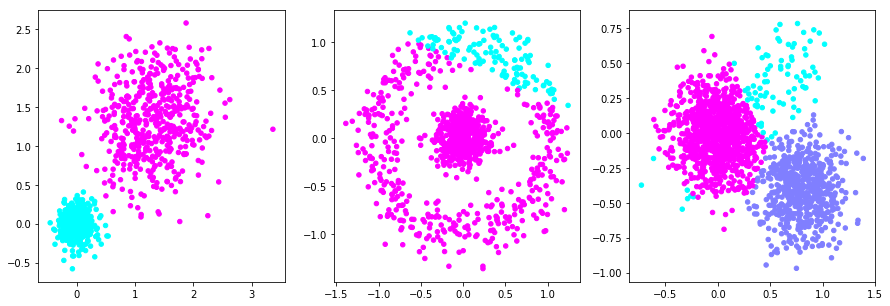

In [49]:
figsize(15, 5)
plt.subplot(1,3,1)
GMM1 = GaussianMixture(n_components=2).fit(X1)
plt.scatter(X1[:,0], X1[:,1], c=GMM1.predict(X1), cmap=plt.get_cmap("cool"), s=20)
plt.subplot(1,3,2)
GMM2 = GaussianMixture(n_components=2).fit(X2)
plt.scatter(X2[:,0], X2[:,1], c=GMM2.predict(X2), cmap=plt.get_cmap("cool"), s=20)
plt.subplot(1,3,3)
GMM3 = GaussianMixture(n_components=3).fit(X3)
plt.scatter(X3[:,0], X3[:,1], c=GMM3.predict(X3), cmap=plt.get_cmap("cool"), s=20)

#### (g)  
Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [128]:
import itertools as it
import scipy.special as spec

def rand_index_score(y_gold, y_predict):
    groups = np.unique(y_gold)
    a_prep = list()
    b = 0
    N = spec.binom(len(y_gold), 2)
    for i, g in enumerate(groups):
        a_prep.append(0)
        for yg, yp in zip(y_gold, y_predict):
            #print(yg, yp, g, i)
            if(yg == yp & yg == g):
                a_prep[i] += 1
            if(yg == g & yp != g):
                b += 1                
    a = 0
    for x in a_prep:
        a += math.factorial(x)
    b = math.factorial(b)
    print(b)
    return a + b / N

**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?  
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?